## AirBnb Blog Post Project
Vikram Tharakan

<u1>
    <li><a href="#Intro">Introduction</a></li>
    <li><a href="#GatheringData">Gathering Data</a></li>
    <li><a href="#ExploringData">Exploring the Data</a></li>
    <li><a href="#Analysis">Analysis</a></li>
    <li><a href="#Conclusion">Conclusion</a></li>
</u1>

<a id= 'Intro'></a>
## Introduction

<a id ='GatheringData'></a>
## Gathering Data

In [126]:
import requests
from io import BytesIO
from zipfile import ZipFile
from os import path, getcwd, makedirs, listdir 
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

There are many way to get the data from kaggle's website (the simplest being simply clicking the download button). Seeing as I will likely use kaggle again, I created a kaggle API token and then downloaded the Boston and Seattle airbnb datasets using the `kaggle dataset download {link location}` command. This was done through the command line, and I figured it would be easier to just say that's how the zip files ended up in this folder.

I will now unzip these folders and save them as local dataframes that I can work with

In [7]:
# Two locations for the data because the files have the same names and I will rename them later
bnb_folder = ['seattle_folder','boston_folder']

In [217]:
zip_names = ['boston.zip','seattle.zip']
location_names = ['https://www.kaggle.com/airbnb/boston/downloads/boston-airbnb-open-data.zip/1','https://www.kaggle.com/airbnb/seattle/downloads/seattle.zip/2']
for i in bnb_folder:
    try:
        makedirs(i)
    except:
        print(str(i[:-7]) +'_folder '+'exists')


seattle_folder exists
boston_folder exists


In [218]:
for i in zip_names:
    with ZipFile(i, 'r') as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall(i[:-4]+'_folder') #Simply because these files have the same name

In [8]:
# Importing each dataset individually and storing each in its own dataframe. Will join along ID soon
for dataset in listdir(bnb_folder[0]):
    if dataset == 'calendar.csv':
        SEA_calendar = pd.read_csv(bnb_folder[0]+'/'+dataset)
    elif dataset == 'listings.csv':
        SEA_listings = pd.read_csv(bnb_folder[0]+'/'+dataset)
    elif dataset == 'reviews.csv':
        SEA_reviews = pd.read_csv(bnb_folder[0]+'/'+dataset)
        
for dataset in listdir(bnb_folder[1]):
    if dataset == 'calendar.csv':
        BOS_calendar = pd.read_csv(bnb_folder[1]+'/'+dataset)
    elif dataset == 'listings.csv':
        BOS_listings = pd.read_csv(bnb_folder[1]+'/'+dataset)
    elif dataset == 'reviews.csv':
        BOS_reviews = pd.read_csv(bnb_folder[1]+'/'+dataset)

> The next few cells are just for my personal gain. Looking at what each datafram contains. Keep in mind we want to think of at least 3 questions that we can answer from this information

In [220]:
print(SEA_calendar.shape)
print(SEA_listings.shape)
print(SEA_reviews.shape)


(1393570, 4)
(3818, 92)
(84849, 6)


In [221]:
SEA_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [222]:
SEA_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [223]:
SEA_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

- Remember that `id` in the listings table is `listing_id` in both of the other tables

### After looking at the basics of the datasets above, here are 3 questions I'd like to answer:

<ol type="I">
    <li><a href="#Q1">How does the average number of booked bnb's fluctuate throughout the year?</a></li>
  <li><a href="#Q2">Were certain words used more often than others in the names of different bnbs? Were any words associated with higher ratings?</a></li>
  <li><a href="#Q3">Can we Predict the Pricing of different bnbs? What factors are the biggest indicators of price?</a></li>
</ol>

<a id = 'ExploringData'></a>
## Exploring the Data

<a id = 'Q1'></a>
### <u>Question 1</u> <br>
<i> How does the average number of booked bnb's fluctuate throughout the year? </i>


I'm going to merge the boston and seattle datasets into one large dataset for the calendar table to answer the first question. In order to do this I'm going to add another row element to the calendar table to indicate which city

In [9]:
SEA_calendar1 = SEA_calendar.copy()
SEA_calendar1['city'] = 'Seattle'
BOS_calendar1 = BOS_calendar.copy()
BOS_calendar1['city'] = 'Boston'


In [10]:
bnb_calendar = pd.concat([SEA_calendar1, BOS_calendar1], ignore_index=True)

In [11]:
#bnb_calendar[bnb_calendar['available'] == False]
bnb_calendar['date'] = pd.to_datetime(bnb_calendar.date)


> In order to get a look at how how this fluctuates, let's bin the data into a month/day bins, and then plot this over the course of the year (2016)

In [12]:
# Creating new subset dataframe that only contains data from bnb's on days where they were booked
bnb_booked_cal = bnb_calendar[bnb_calendar['available'] == 'f'].copy()

# Generating time bins which will be formatted 'm/y'
time_bin = []
for i in bnb_booked_cal.date:
    time_bin.append(str(i.month) + '/' + str(i.year%100))

In [13]:
# Adding time_bin column to the booked dataframe
bnb_booked_cal['time_bin'] = time_bin

In [14]:
# Create an ordered list of time bins
bnb_booked_cal.time_bin.value_counts()

9/16     102543
10/16    100741
12/16     81466
11/16     81452
5/17      57566
7/17      56203
4/17      56198
3/17      55985
8/17      55605
6/17      54849
1/17      49923
1/16      47665
7/16      44136
2/17      43598
8/16      42011
4/16      38503
5/16      38387
2/16      37401
6/16      37296
3/16      34420
9/17       8933
Name: time_bin, dtype: int64

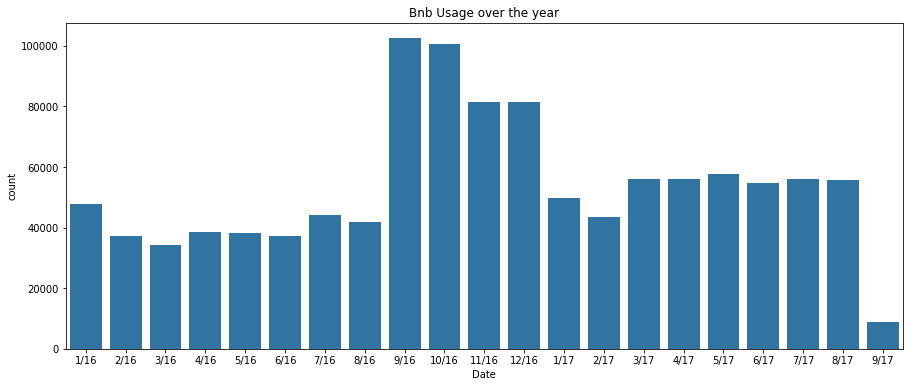

In [15]:
# Plot histogram of use time
base_color = sb.color_palette()[0]
time_order = ['1/16', '2/16', '3/16', '4/16' , '5/16', '6/16', '7/16', '8/16', '9/16', '10/16', '11/16', 
              '12/16', '1/17', '2/17' , '3/17', '4/17', '5/17', '6/17', '7/17', '8/17', '9/17']

plt.figure(figsize = (15,6))
sb.countplot(data = bnb_booked_cal, x = 'time_bin', color = base_color, order = time_order);
plt.xlabel('Date');
plt.title('Bnb Usage over the year');

* It appears that across the two cities air bnb was booked the most in the september/october time frame. <b>However, this was across two cities! Lets split up the data by city</b>

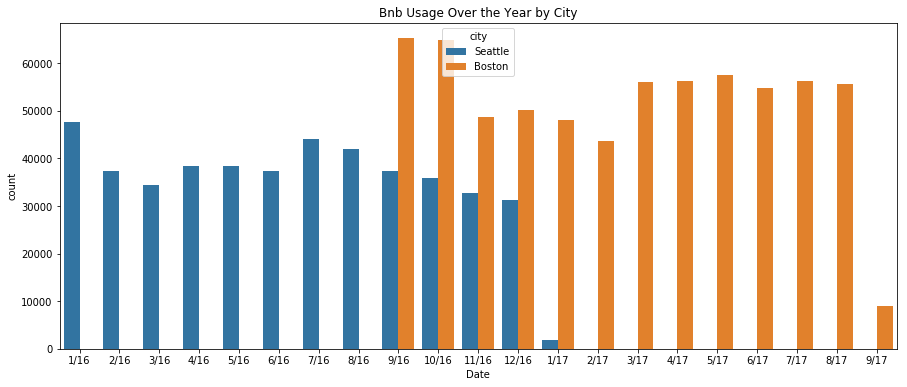

In [16]:
plt.figure(figsize = (15,6))
sb.countplot(data = bnb_booked_cal, x = 'time_bin', order = time_order, hue = 'city');
plt.xlabel('Date');
plt.title('Bnb Usage Over the Year by City');

This explains the large peak we saw earlier; 9/16-12/16 were so much larger due to the overlap of data. It appears that each city had different peak times. The following bullet points come from the graph above, and the few queries shown below
* <u>Seattle</u>: Seattle had it's peak in January, specifically the first weekend of January. A quick look at the calendar at that time shows that 1/4/16 landed on a monday (after New Years weekend, explaining the spike around then). It seems that Seattle is a popular New Year's destination
* <u>Boston</u>: Boston had it's peak in September, with the peak booking day being the day after labor day weekend. 2 weeks after labor day weekend was also very popular, suggesting September as a whole is a pretty popular month in Boston.It appears as though people like to travel here during the end of summer/early fall much more than the winter. This is very different than what we see with the Seattle booking rates. It also appears that on average, Boston is a more popular Airbnb destination than Seattle

In [17]:
# Understanding why Seattle had it's peak in Jan
bnb_booked_cal[bnb_booked_cal['city'] == 'Seattle'].date.value_counts().head()

2016-01-04    2083
2016-01-07    2042
2016-01-08    2036
2016-01-06    1992
2016-01-09    1962
Name: date, dtype: int64

In [18]:
bnb_booked_cal[bnb_booked_cal['city'] == 'Boston'].date.value_counts().head()

2016-09-06    3016
2016-09-16    2817
2016-09-15    2811
2016-09-14    2791
2016-09-17    2783
Name: date, dtype: int64

<a id = 'Q2'></a>
### <u>Question 2</u><br>
<i>Were certain words used more often than others in the names of different bnbs? Were any words associated with higher ratings?</i>


In [19]:
SEA_listings1 = SEA_listings.copy()
SEA_listings1['city'] = 'Seattle'
BOS_listings1 = BOS_listings.copy()
BOS_listings1['city'] = 'Boston'
bnb_listings = pd.concat([SEA_listings1, BOS_listings1], ignore_index=True, sort = False)

In [20]:
bnb_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,access,interaction,house_rules
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,WASHINGTON,f,moderate,f,f,2,4.07,NaN,NaN,NaN
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,WASHINGTON,f,strict,t,t,6,1.48,NaN,NaN,NaN
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,WASHINGTON,f,strict,f,f,2,1.15,NaN,NaN,NaN
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,WASHINGTON,f,flexible,f,f,1,NaN,NaN,NaN,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,WASHINGTON,f,strict,f,f,1,0.89,NaN,NaN,NaN


In [21]:
# Compiling a dictionary that counts the number of times a specific word shows up in the name for all listings
name_list = bnb_listings['name']
word_counter = dict()
for i in name_list:
    my_string = i.lower().split()
    for item in my_string:
        if item in word_counter:
            word_counter[item] += 1
        else:
            word_counter[item] = 1
    

In [22]:
# Displaying the top 50 words in descending order in terms of the number of times it appears in the description
word_counter
import operator
sorted_words = sorted(word_counter.items(), key=operator.itemgetter(1), reverse = True)
sorted_words[:50]

[('in', 1675),
 ('room', 932),
 ('private', 669),
 ('boston', 584),
 ('hill', 554),
 ('apartment', 551),
 ('bedroom', 541),
 ('the', 528),
 ('cozy', 500),
 ('seattle', 489),
 ('studio', 485),
 ('near', 465),
 ('home', 463),
 ('to', 427),
 ('-', 402),
 ('1', 401),
 ('2', 379),
 ('modern', 366),
 ('downtown', 364),
 ('of', 345),
 ('apt', 342),
 ('&', 337),
 ('with', 321),
 ('end', 309),
 ('capitol', 292),
 ('spacious', 282),
 ('house', 276),
 ('view', 273),
 ('and', 269),
 ('south', 244),
 ('beautiful', 226),
 ('back', 226),
 ('heart', 217),
 ('bay', 216),
 ('charming', 215),
 ('1br', 215),
 ('2br', 215),
 ('condo', 210),
 ('on', 207),
 ('a', 202),
 ('luxury', 194),
 ('sunny', 191),
 ('by', 185),
 ('beacon', 185),
 ('bed', 180),
 ('location', 178),
 ('great', 173),
 ('queen', 166),
 ('suite', 166),
 ('close', 158)]

Ignoring common words, like "in", "of", and "and", and only looking at the top <b>descriptive</b> words, we see that the top descriptive words are
* private
* cozy
* near
* modern
* downtown
* spacious
* view
* and so on...

Perhaps almost unintentionally this word break down also gave a slight insight into the breakdown of the types of bnbs offered and their relative frequency
* room+bedroom (932+541)
* apartments+apt (551+342)
* studio (485)
* home+house (463+276)<br>
( We could also look into this breakdown, but I am going to stick with the current question for now)

> It would be interesting to see how the price and rating breakdown changed with the usage of these words. While we could query the answers from the dataframe individually, I thought it might be nice to create a scatter plot of the associated price/rating for each word. To do this, I'm going to create a separate data frame that contains the values for the average price and rating for each word, as well as the overall average price and rating. Then, using that dataframe we can create a nice scatter plot of the data

In [23]:
# Changing Prices to floats from strings. Have to remove '$' character and remove commas from strings
price_list=[]
for i in bnb_listings.price:
    price_list.append(i[1:])
for i in range(len(price_list)):
    price_list[i] = price_list[i].replace(",", "")

In [24]:
# Changing the price colomn to floats
bnb_listings.price = price_list
bnb_listings.price = bnb_listings.price.astype(float)

In [25]:
#Creating the dictionary from 3 separate lists

# List of the top words
top_words = ['private', 'cozy','near','modern','downtown','spacious','view','beautiful','charming','luxury','sunny', 'average']

# List of the average prices associated with each word
prices = [bnb_listings[bnb_listings['name'].str.contains('private') == True].price.mean(),
          bnb_listings[bnb_listings['name'].str.contains('cozy') == True].price.mean(),
          bnb_listings[bnb_listings['name'].str.contains('near') == True].price.mean(),
          bnb_listings[bnb_listings['name'].str.contains('modern') == True].price.mean(),
          bnb_listings[bnb_listings['name'].str.contains('downtown') == True].price.mean(),
          bnb_listings[bnb_listings['name'].str.contains('spacious') == True].price.mean(),
          bnb_listings[bnb_listings['name'].str.contains('view') == True].price.mean(),
          bnb_listings[bnb_listings['name'].str.contains('beautiful') == True].price.mean(),
          bnb_listings[bnb_listings['name'].str.contains('charming') == True].price.mean(),
          bnb_listings[bnb_listings['name'].str.contains('luxury') == True].price.mean(),
          bnb_listings[bnb_listings['name'].str.contains('sunny') == True].price.mean(),
          bnb_listings.price.mean()]

# List of average rating associated with each word
ratings = [bnb_listings[bnb_listings['name'].str.contains('private') == True].review_scores_rating.mean(),
          bnb_listings[bnb_listings['name'].str.contains('cozy') == True].review_scores_rating.mean(),
          bnb_listings[bnb_listings['name'].str.contains('near') == True].review_scores_rating.mean(),
          bnb_listings[bnb_listings['name'].str.contains('modern') == True].review_scores_rating.mean(),
          bnb_listings[bnb_listings['name'].str.contains('downtown') == True].review_scores_rating.mean(),
          bnb_listings[bnb_listings['name'].str.contains('spacious') == True].review_scores_rating.mean(),
          bnb_listings[bnb_listings['name'].str.contains('view') == True].review_scores_rating.mean(),
          bnb_listings[bnb_listings['name'].str.contains('beautiful') == True].review_scores_rating.mean(),
          bnb_listings[bnb_listings['name'].str.contains('charming') == True].review_scores_rating.mean(),
          bnb_listings[bnb_listings['name'].str.contains('luxury') == True].review_scores_rating.mean(),
          bnb_listings[bnb_listings['name'].str.contains('sunny') == True].review_scores_rating.mean(),
          bnb_listings.review_scores_rating.mean()]

temp_dict = {'Word':top_words,'Prices':prices,'Avg_Ratings':ratings}
words_df = pd.DataFrame(temp_dict)

In [26]:
words_df

,Word,Prices,Avg_Ratings
0,private,114.681159,93.840000
1,cozy,104.947368,91.636364
2,near,121.429043,92.602510
3,modern,145.021277,92.487805
4,downtown,117.517647,93.776119
5,spacious,128.969697,92.888889
6,view,156.410072,94.861111
7,beautiful,158.730769,92.869565
8,charming,86.833333,96.272727
9,luxury,140.125000,97.800000


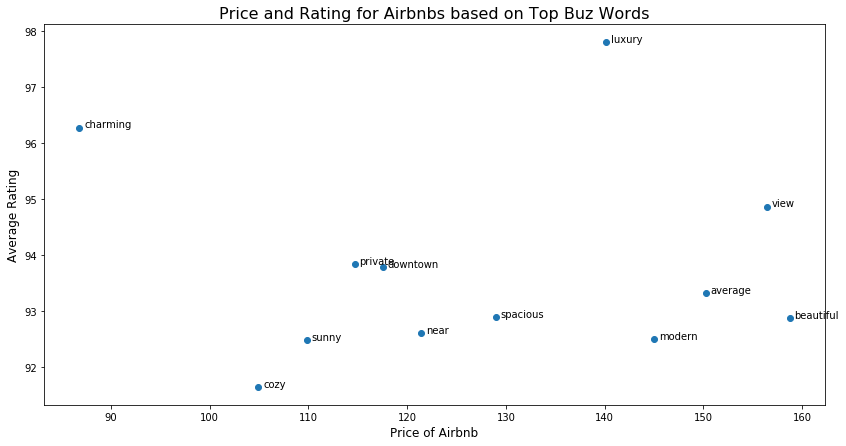

In [107]:
fig = plt.figure(figsize = (14,7))
ax = fig.add_subplot(111)
ax.scatter(data = words_df, x = 'Prices',y = 'Avg_Ratings');
ax.set_ylabel('Average Rating',size = 12);
ax.set_xlabel('Price of Airbnb',size = 12);
ax.set_title('Price and Rating for Airbnbs based on Top Buz Words',size = 16);
for i, txt in enumerate(words_df.Word):
    ax.annotate(txt, (words_df.Prices.iat[i]+.5,words_df.Avg_Ratings.iat[i]))
#ax.set_ylim(ymin=0.0, ymax=12);

#### While most of these "buzz words" have similar results to the average listing, there are a few takeaways from this plot
* Most of these "top buzz words" were associated with a slightly lower price with about the same rating compared to the average. This could be due to many reasons, such as outliers in the dataset however, so we can't read too much into that without further digging
* "Charming" seems to be the <i>best</i> buzz word for listings in terms of average rating and price balance. These listings appear to be quite a bit cheaper than the rest with a slightly higher satisfaction rating. I guess I'll have to look out for charming bnb's next time I book a stay!

> Let's look and see if this anomolly with the word charming is just due to the difference in pricing between Seattle and Boston

In [106]:
# Remaking the words data fram to include the mean price for each buzz word in each city.
# Since we have changed the price column from Strings to floats, I used the bnb_listings
# table to start with and then pick off Seattle bnb's and Boston bnb's rather than just
# starting with the Boston and Seatte data frames that we have stored already

# List of the average prices associated with each word
SEA1_listings = bnb_listings[bnb_listings['city'] == 'Seattle'].copy()
BOS1_listings = bnb_listings[bnb_listings['city'] == 'Boston'].copy()

# Creating top words again. Has to be twice as long, for each city
top_words_city = top_words*2

# Creating city list, that will eventually be the identifier for each point
city = ['Seattle']*12 + ['Boston']*12

# Prices for each buzz word in each city
prices_city = [SEA1_listings[SEA1_listings['name'].str.contains('private') == True].price.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('cozy') == True].price.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('near') == True].price.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('modern') == True].price.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('downtown') == True].price.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('spacious') == True].price.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('view') == True].price.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('beautiful') == True].price.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('charming') == True].price.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('luxury') == True].price.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('sunny') == True].price.mean(),
          SEA1_listings.price.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('private') == True].price.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('cozy') == True].price.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('near') == True].price.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('modern') == True].price.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('downtown') == True].price.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('spacious') == True].price.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('view') == True].price.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('beautiful') == True].price.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('charming') == True].price.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('luxury') == True].price.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('sunny') == True].price.mean(),
          BOS1_listings.price.mean()]

# List of average rating associated with each word in each city separately
ratings_city = [SEA1_listings[SEA1_listings['name'].str.contains('private') == True].review_scores_rating.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('cozy') == True].review_scores_rating.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('near') == True].review_scores_rating.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('modern') == True].review_scores_rating.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('downtown') == True].review_scores_rating.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('spacious') == True].review_scores_rating.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('view') == True].review_scores_rating.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('beautiful') == True].review_scores_rating.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('charming') == True].review_scores_rating.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('luxury') == True].review_scores_rating.mean(),
          SEA1_listings[SEA1_listings['name'].str.contains('sunny') == True].review_scores_rating.mean(),
          SEA1_listings.review_scores_rating.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('private') == True].review_scores_rating.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('cozy') == True].review_scores_rating.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('near') == True].review_scores_rating.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('modern') == True].review_scores_rating.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('downtown') == True].review_scores_rating.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('spacious') == True].review_scores_rating.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('view') == True].review_scores_rating.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('beautiful') == True].review_scores_rating.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('charming') == True].review_scores_rating.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('luxury') == True].review_scores_rating.mean(),
          BOS1_listings[BOS1_listings['name'].str.contains('sunny') == True].review_scores_rating.mean(),
          BOS1_listings.review_scores_rating.mean()]

# Putting all these lists together in a dataframe
temp_dict_city = {'Word':top_words_city,'Prices':prices_city,'Avg_Ratings':ratings_city,'City':city}
words_df_city = pd.DataFrame(temp_dict_city)

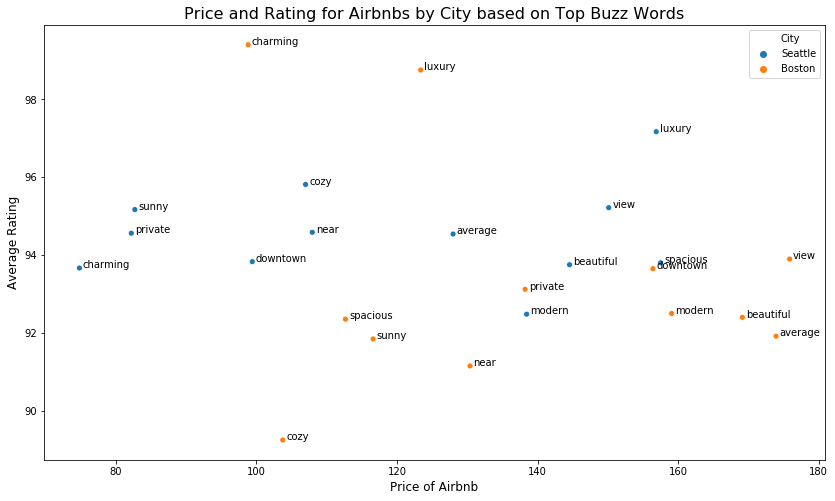

In [109]:
# Plotting the new data frame that is separated by city
fig = plt.figure(figsize = (14,8))
ax = sb.scatterplot(data = words_df_city, x = 'Prices',y = 'Avg_Ratings', hue = 'City')
ax.set_ylabel('Average Rating',size = 12);
ax.set_xlabel('Price of Airbnb',size = 12);
ax.set_title('Price and Rating for Airbnbs by City based on Top Buzz Words',size = 16);
for i, txt in enumerate(words_df_city.Word):
    ax.annotate(txt, (words_df_city.Prices.iat[i]+.5,words_df_city.Avg_Ratings.iat[i]))

> <b> Thus we still see <u>charming</u> is the lowest price regardless of city!!</b> The rating may have not been as high for the Seattle charming bnbs, but the overall trend is still there

<a id = 'Q3'></a>
### <u>Question 3</u><br>
<i>Can we Predict the Pricing of different bnbs? What factors are the biggest indicators of price?</i>

> Let's first look at just the numeric variables that affect price. Earlier we saw that a lot of the data was incomplete, such as the ones listed below

Nearly Complete
* 'accommodates' ----------------------- complete
* 'beds' -------------------------------- missing < 100
* 'bathrooms' -------------------------- missing < 100
* 'bedrooms' --------------------------- missing < 100
* 'extra_people'  ---> should be a float, is a string (no missing data)

Lots of missing data
* 'square_feet' ------------------------ 153 non-null float64
* 'security_deposit'-------------------- 3208 non-null object
* 'cleaning_fee' ----------------------- 5266 non-null object
* 'review_scores_rating' --------------- missing about 1000
* 'review_scores_accuracy' ------------- missing about 1000


> We can fill in `beds`, `bathrooms`, and `bedrooms` using either mean or mode, as their is not much missing information. We can use `extra_people` if we turn the datatype into a float from a string

> For `square_feet`, `security_deposit`, `cleaning_fee`, `review_scores_rating`, and `review_scores_accuracy` there is a lot more missing information so we have to consider if we want to include this in our data, and if so how to do it (mean, median, k-nn?). We'll get to this question later. Let's first build up our linear model using only the first block of numeric variables.


In [186]:
# Making a copy of the data before we start filling 
fill_df = bnb_listings.copy()

In [187]:
# Create a list from the extra_person column without commas and drop the dollar sign.
add_person =[]
for i in fill_df.extra_people:
    add_person.append(i[1:])
for i in range(len(add_person)):
    add_person[i] = add_person[i].replace(",", "")
    
# Changing the extra_person colomn from strings to floats
fill_df.extra_people = add_person
fill_df.extra_people = fill_df.extra_people.astype(float)

In [188]:
clean_fee = []
for i in fill_df.cleaning_fee:
    if type(i) != float:
        clean_fee.append(i[1:])
    else:
        clean_fee.append(i)

for i in range(len(clean_fee)):
    if type(clean_fee[i]) != float:
        clean_fee[i] = clean_fee[i].replace(",", "")

fill_df.cleaning_fee = clean_fee
fill_df.cleaning_fee = fill_df.cleaning_fee.astype(float)

In [189]:
deposit = []
for i in fill_df.security_deposit:
    if type(i) != float:
        deposit.append(i[1:])
    else:
        deposit.append(i)

for i in range(len(deposit)):
    if type(deposit[i]) != float:
        deposit[i] = deposit[i].replace(",", "")

fill_df.security_deposit = deposit
fill_df.security_deposit = fill_df.security_deposit.astype(float)

In [190]:
fill_df.security_deposit.head()

0       NaN
1     100.0
2    1000.0
3       NaN
4     700.0
Name: security_deposit, dtype: float64

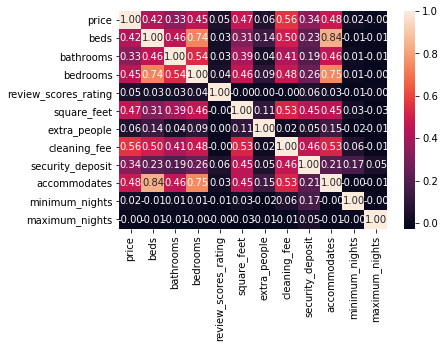

In [191]:
# Get an idea of what we want to include in our model and what we can ignore
sb.heatmap(fill_df[['price','beds', 'bathrooms', 'bedrooms','review_scores_rating','square_feet', 'extra_people',
                   'cleaning_fee', 'security_deposit', 'accommodates', 
                    'minimum_nights', 'maximum_nights']].corr(), annot = True, fmt = ".2f");



> The heatmap above gives us a good indicator of what numerical vaiables we might want to use in our model and which we can avoid. It seems like minimum and maximum nights are two that can be easily dropped

In [200]:
#Fill in bed, bathrooms, and bedrooms column with the mode

# Mean function
fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
fill_df[['beds', 'bathrooms', 'bedrooms','reviews_per_month']] = fill_df[['beds', 'bathrooms', 'bedrooms', 'reviews_per_month']].apply(fill_mean, axis=0)

In [202]:
# Using min nights and max nights made model worse so they were omitted
X = fill_df[['accommodates', 'guests_included','beds', 'bathrooms', 'bedrooms', 'extra_people', 'reviews_per_month']]
y = fill_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train,y_train)

preds = lm_model.predict(X_test)
r2_score(y_test,preds)

0.3510108708524029

> We see that above we achieved an r^2 value of .35 using all the numerical values of interest. However there are several other categorical variables we should be concerned with like
* 'city' ------------------ complete
* 'room_type' ---------- complete
* 'property_type'   ------ missing 4, see if you can fill in manually from context
* 'bed_type' ----------- complete
* 'amenities' ----------- would have to recategorize so we will ignore this for now
 

In [229]:
fill_df.property_type.value_counts()

Apartment          4320
House              2295
Condominium         322
Townhouse           172
Loft                 79
Bed & Breakfast      78
Other                39
Cabin                21
Boat                 20
Camper/RV            14
Bungalow             13
Villa                 6
Tent                  5
Entire Floor          4
Dorm                  4
Treehouse             3
Chalet                2
Yurt                  1
Guesthouse            1
Name: property_type, dtype: int64

In [239]:
# Find the location of the null property types in our data frame. Then I looked at each manually to see if I could
# classify each based on the information in the Bnb listing

null_property_locs = np.where(pd.isnull(fill_df.property_type))
print(null_property_locs)
fill_df.loc[7211]

'''
2184 = Apartment
5139 = Apartment
5879 = Other (looks like it's a hotel room, and idk where to put that so let's classify it as other for now)
7211 = Guesthouse

'''


(array([2184, 5139, 5879, 7211]),)


"\n2184 = Apartment\n5139 = Apartment\n5879 = Other (looks like it's a hotel room, and idk where to put that so let's classify it as other for now)\n7211 = Guesthouse\n\n"

In [241]:
# Filling each of these values manually
fill_df.loc[2184, 'property_type'] = 'Apartment'
fill_df.loc[5139, 'property_type'] = 'Apartment'
fill_df.loc[5879, 'property_type'] = 'Other'
fill_df.loc[7211, 'property_type'] = 'Guesthouse'

#### Now let's being creating a 

<a id = 'Analysis'></a>
## Analysis

<a id = 'Conclusion'></a>
## Conclusion